# Week 9 — Deep Learning Basics (PyTorch)

**Goals**
- Understand tensors, datasets, dataloaders
- Build a small MLP classifier on synthetic data
- Train, evaluate, and visualize decision boundary

## 0) Setup

In [1]:
# Colab/local: install PyTorch if missing (CPU build is fine for demo)
# In Colab, PyTorch is usually preinstalled.
# !pip -q install torch matplotlib scikit-learn
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import numpy as np

print('torch:', torch.__version__)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

torch: 2.8.0


'cpu'

## 1) Data (make_moons synthetic)

In [2]:
X, y = make_moons(n_samples=1200, noise=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.long)

train_ds = TensorDataset(X_train_t, y_train_t)
test_ds = TensorDataset(X_test_t, y_test_t)

train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=256)
len(train_ds), len(test_ds)

(960, 240)

## 2) Model

In [3]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 32), nn.ReLU(),
            nn.Linear(32, 32), nn.ReLU(),
            nn.Linear(32, 2)
        )
    def forward(self, x): return self.net(x)

model = MLP().to(device)
opt = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()
model

MLP(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=2, bias=True)
  )
)

## 3) Train loop

In [4]:
def train_epoch(model, dl):
    model.train(); total=0; correct=0; loss_sum=0.0
    for xb, yb in dl:
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad()
        out = model(xb)
        loss = loss_fn(out, yb)
        loss.backward(); opt.step()
        loss_sum += loss.item()*len(xb)
        pred = out.argmax(1)
        correct += (pred==yb).sum().item(); total += len(xb)
    return loss_sum/total, correct/total

def eval_epoch(model, dl):
    model.eval(); total=0; correct=0; loss_sum=0.0
    with torch.no_grad():
        for xb, yb in dl:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb); loss = loss_fn(out, yb)
            loss_sum += loss.item()*len(xb)
            pred = out.argmax(1)
            correct += (pred==yb).sum().item(); total += len(xb)
    return loss_sum/total, correct/total

train_hist, val_hist = [], []
for epoch in range(20):
    tr_loss, tr_acc = train_epoch(model, train_dl)
    te_loss, te_acc = eval_epoch(model, test_dl)
    train_hist.append((tr_loss,tr_acc)); val_hist.append((te_loss,te_acc))
    if (epoch+1)%5==0:
        print(f"epoch {epoch+1}: train acc={tr_acc:.3f}, test acc={te_acc:.3f}")

epoch 5: train acc=0.827, test acc=0.838
epoch 10: train acc=0.885, test acc=0.883
epoch 15: train acc=0.899, test acc=0.887
epoch 20: train acc=0.917, test acc=0.912


## 4) Visualize decision boundary

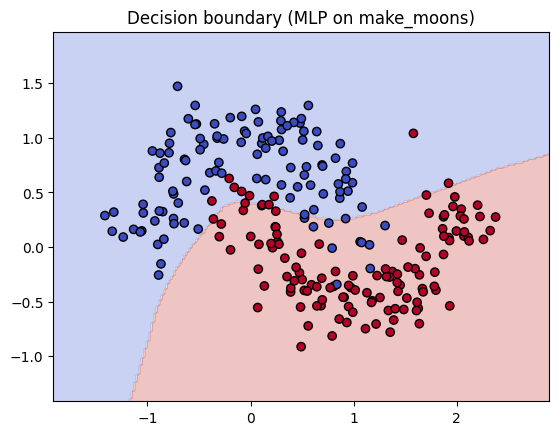

In [5]:
xx, yy = np.meshgrid(np.linspace(X[:,0].min()-0.5, X[:,0].max()+0.5, 200),
                     np.linspace(X[:,1].min()-0.5, X[:,1].max()+0.5, 200))
grid = np.c_[xx.ravel(), yy.ravel()]
with torch.no_grad():
    zz = model(torch.tensor(grid, dtype=torch.float32).to(device)).argmax(1).cpu().numpy()
zz = zz.reshape(xx.shape)

plt.figure()
plt.contourf(xx, yy, zz, alpha=0.3, cmap='coolwarm')
plt.scatter(X_test[:,0], X_test[:,1], c=y_test, cmap='coolwarm', edgecolor='k')
plt.title('Decision boundary (MLP on make_moons)')
plt.show()